# Load the Dataset

In [1]:
import pandas as pd
#encode categorical and numerical columns with label and ordinal encoding
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
import numpy as np
#do random forest classification
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.decomposition import PCA
#import train_test_split
from sklearn.model_selection import train_test_split,PredefinedSplit

seed = 42
#read the dataset
df = pd.read_csv('train_dataset.csv')
df.drop(columns=["label"], inplace=True)
#DATA CLEANING

#filter numerical columns
num_columns = df.select_dtypes(include=[np.number]).columns.tolist()

#filter categorical columns
cat_columns = df.select_dtypes(include=[object]).columns.tolist()

# replace '-' values in n columns with the mean of the column(both int and float columns)
for column in num_columns:
    df[column] = df[column].replace('-', df[column].mean())

# replace '-' values in categorical columns with the mode of the column
for column in cat_columns:
    df[column] = df[column].replace('-', df[column].mode().iloc[0])

# Convert all categorical columns to strings
df[cat_columns] = df[cat_columns].astype(str)

encoder = OrdinalEncoder()
df[cat_columns] = encoder.fit_transform(df[cat_columns])

y = df["type"].to_numpy()
X = df.drop(columns=["type"]).to_numpy()

oe = OrdinalEncoder()
df_oe = oe.fit_transform(df.select_dtypes(include=['object']))
df.loc[:, df.select_dtypes(include=['object']).columns] = df_oe
X = df.to_numpy()

le = LabelEncoder()
y = le.fit_transform(y)

indeces = np.arange(X.shape[0])
# Create predefined split for train, validation, and test
train_idx, temp_idx, y_train, y_temp = train_test_split(indeces, y, test_size=0.2, random_state=seed, stratify=y)

X_train = X[train_idx,:]
y_train = y[train_idx]


val_idx, test_idx, y_val, y_test = train_test_split(temp_idx, y_temp, test_size=0.5, random_state=seed, stratify=y_temp)
X_val = X[val_idx,:]
y_val = y[val_idx]
X_test = X[test_idx,:]
y_test = y[test_idx]

# Create PredefinedSplit object
test_fold = np.zeros(len(X))
test_fold[train_idx] = -1
test_fold[val_idx] = 0
ps = PredefinedSplit(test_fold=test_fold)




C:\Users\rinal\AppData\Local\Temp\ipykernel_35884\2401007773.py:15: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('train_dataset.csv')


In [ ]:

#do oversampling
# from imblearn.over_sampling import SMOTE
# smote = SMOTE(sampling_strategy='minority', random_state=seed)
# X_train, y_train = smote.fit_resample(X_train, y_train)


scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X = scaler.transform(X)

pre = PCA(svd_solver='full', n_components='mle')
pre.fit(X_train)
X = pre.transform(X)
X_train = pre.transform(X_train)
X_val = pre.transform(X_val)
X_test = pre.transform(X_test)

#PRINT DIMENSIONS
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)



(493601, 23)
(493601,)
(61700, 23)
(61700,)
(61701, 23)
(61701,)


# SVM

In [48]:
# from sklearn.svm import SVC
# from sklearn.model_selection import GridSearchCV
# import pickle

# scoring = ['balanced_accuracy','f1_weighted']

# param_grid = {'C': [0.1, 1,10,100,1000], 
#               'gamma': [1,0.1,0.01,0.001],
#               'kernel': ['rbf','sigmoid','linear']}  

# #cast x and y train in numpy arrays
# X_train = np.array(X_train)
# y_train = np.array(y_train)

# grid = GridSearchCV(SVC(random_state=seed), param_grid,verbose=10,cv=ps,n_jobs=-1,scoring=scoring)
# grid.fit(X_train, y_train)
# file = open("svc.save","wb")
# pickle.dump(grid.best_estimator_, file)
# print("Best hypearparameters: ",grid.best_estimator_)
# print("Best performance:",  grid.best_score_)
# file.close()



# Random Forest

Fitting 1 folds for each of 1 candidates, totalling 1 fits
Best hyperparameters:  RandomForestClassifier(n_jobs=-1, random_state=42)
Best performance: 0.9937753136051525


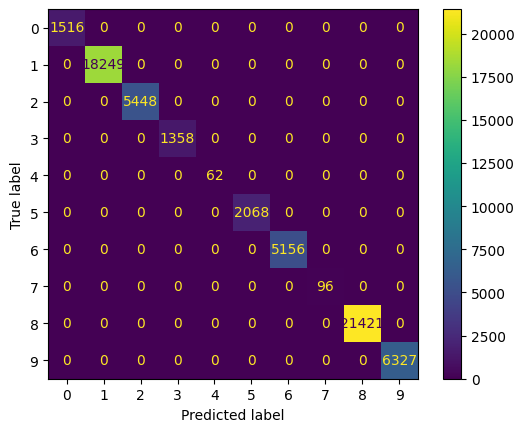

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1516
           1       1.00      1.00      1.00     18249
           2       1.00      1.00      1.00      5448
           3       1.00      1.00      1.00      1358
           4       1.00      1.00      1.00        62
           5       1.00      1.00      1.00      2068
           6       1.00      1.00      1.00      5156
           7       1.00      1.00      1.00        96
           8       1.00      1.00      1.00     21421
           9       1.00      1.00      1.00      6327

    accuracy                           1.00     61701
   macro avg       1.00      1.00      1.00     61701
weighted avg       1.00      1.00      1.00     61701

Balanced accuracy:  1.0
F1 score:  1.0


In [3]:
#import random forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import pickle

param_grid = {  'n_estimators': [100],
                'criterion': ['gini']
                }  

scoring = ['balanced_accuracy','f1_weighted']

grid = GridSearchCV(RandomForestClassifier(random_state=seed,n_jobs=-1), param_grid,verbose=10,cv=ps,n_jobs=-1,scoring=scoring, refit='balanced_accuracy')
grid.fit(X, y)
file = open("rf.save","wb")
pickle.dump(grid.best_estimator_, file)
print("Best hyperparameters: ",grid.best_estimator_)
print("Best performance:",  grid.best_score_)
file.close()


#do prediction on the test set
y_pred = grid.predict(X_test)
#plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

#do classification report
from sklearn.metrics import classification_report,balanced_accuracy_score,f1_score
print(classification_report(y_test, y_pred))

#calculate balanced accuracy
print("Balanced accuracy: ", balanced_accuracy_score(y_test, y_pred))

#calculate f1 score
print("F1 score: ", f1_score(y_test, y_pred, average='weighted'))


# KNN

Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV 1/1; 1/1] START n_neighbors=15, p=1.........................................


c:\Users\rinal\Desktop\UNIBO\DA\data-analytics\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\rinal\Desktop\UNIBO\DA\data-analytics\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[CV 1/1; 1/1] END n_neighbors=15, p=1; balanced_accuracy: (test=0.983) f1_weighted: (test=0.999) total time= 1.2min
Best hyperparameters:  KNeighborsClassifier(n_neighbors=15, p=1)
Best performance: 0.9826203016720731


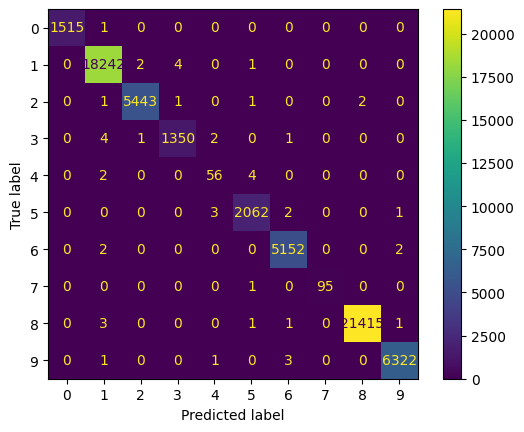

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1516
           1       1.00      1.00      1.00     18249
           2       1.00      1.00      1.00      5448
           3       1.00      0.99      1.00      1358
           4       0.90      0.90      0.90        62
           5       1.00      1.00      1.00      2068
           6       1.00      1.00      1.00      5156
           7       1.00      0.99      0.99        96
           8       1.00      1.00      1.00     21421
           9       1.00      1.00      1.00      6327

    accuracy                           1.00     61701
   macro avg       0.99      0.99      0.99     61701
weighted avg       1.00      1.00      1.00     61701

Balanced accuracy:  0.988020963025576
F1 score:  0.9992057756347136


In [4]:

#do the same with knn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import pickle
param_grid = {'n_neighbors': [15],
            'p': [1]}
scoring = ['balanced_accuracy','f1_weighted']
grid = GridSearchCV(KNeighborsClassifier(), param_grid,verbose=10,cv=ps,scoring=scoring, refit='balanced_accuracy')
grid.fit(X, y)
#save the best model
print("Best hyperparameters: ",grid.best_estimator_)
print("Best performance:",  grid.best_score_)
#save the model with the best hyperparameters
file = open("knn.save","wb")
pickle.dump(grid.best_estimator_, file)
file.close()

#do prediction on the test set
y_pred = grid.predict(X_test)
#plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

#do classification report
from sklearn.metrics import classification_report,balanced_accuracy_score,f1_score
print(classification_report(y_test, y_pred))

#calculate balanced accuracy
print("Balanced accuracy: ", balanced_accuracy_score(y_test, y_pred))

#calculate f1 score
print("F1 score: ", f1_score(y_test, y_pred, average='weighted'))